# Gaussian Model

## Swaption pricing

The swaption price at time 0, $V_0$, is given by the following expression $$
    \begin{array}{ll} V_0 &= \mathbb{E}_{\mathbb{Q}}\Big[e^{-\int_{0}^{T_0} r(s) \ \mathrm{d}s}Swap(T_0)^+\Big] \\
&= P(0,T_0) \ \mathbb{E}_{\mathbb{Q}}\Big[e^{-\int_{0}^{T_0} x(s) \ \mathrm{d}s}\Big(1-P(T_0,T_N,x(T_0),y(T_0))-K\sum_{n=0}^{N-1} \tau_n P(T_0,T_{n+1},x(T_0),y(T_0)\Big)^+\Big]
\end{array}
$$
And $$\forall n \in [|0,N|], \quad P(T_0,T_n,x,y) = \frac{P(0,T_n)}{P(0,T_0)} e^{-G(T_0,T_N)x-\frac{1}{2}G(T_0,T_N)^2 y}$$

One will use a Monte Carlo estimator of the expectation above by using M independent simulations $S_m$ so that
$$\hat{V_0} = \frac{1}{M} \sum_{m=1}^M S_m$$
$$\forall m, \ S_m = e^{I_m} \ \Big(P(0,T_0)-P(0,T_0)P(T_0,T_n,x_m,y_m) - KP(0,T_0) A(T_0,x_m,y_m)\Big)^+$$
Where we have noted $x_m,y_m,I_m$ the m-th Euler simulation of $x(T_0),y(T_0), I(T_0)$

## Euler discretization

We aim to discretize the following differential system with an Euler scheme

$$\left\{
    \begin{array}{ll}
       \mathrm{d}x(t) &= (y(t) - \chi(t) x(t)) \ \mathrm{d}t \ + \ \sigma_r(t) \ \mathrm{d}Wt\\
       \mathrm{d}y(t) &= (\sigma_r(t)^2-2\chi(t)y(t)) \ \mathrm{d}t
    \end{array}
\right.$$

**Constant mean reversion and linear local volatility:** First, let for simplicity $$\chi(t) = \chi \in \mathbb{R}$$ and $$\sigma_r(t) = \sigma_r(t,x(t),y(t)) = \lambda(a + bx(t))$$

One defines a discretized time interval $0=t_0 < t_1 < ... < t_N = T_0$ and $\forall i \in [|0,N-1|], \ \Delta_i = t_{i+1} -t_i$

We will simulate $x(T_O)$ and $y(T_O)$ thanks to the scheme:
$$\left\{
    \begin{array}{ll}
       x_{t_{i+1}} &= x_{t_i} + (y_{t_i} - \chi x_{t_i}) \ \Delta_i \ + \ \lambda(a+bx_{t_i}) \ \sqrt{\Delta_i} Z_i \qquad  ,Z_i \sim \mathcal{N}(0,1) \\
       y_{t_{i+1}} &= y_{t_i} + (\lambda^2(a+bx_{t_i})^2-2\chi y_{t_i}) \ \Delta_i
    \end{array}
\right.$$

What's more, one has to simulate the variable $$I(T_0)=-\int_{0}^{T_0} x(s) \ \mathrm{d}s$$
As $\mathrm{d}I(t) = -x(t) \ \mathrm{d}t$, in line with the results above, one defines
$$I_{t_{i+1}} = I_{t_i} - x_{t_i} \ \Delta_i$$

**Remark:** $y(t) = \int_{0}^{t} e^{-2\chi(t-u)} (a+bx(u))^2 \ \mathrm{d}u$ is a path dependent integral and could be calculated with the values $\{x_{t_i}, \ t_i<t\}$

## Simulation

In order to price swaptions, one needs the values of the zero coupon bonds for each maturity $\Big(P(0,T_i)\Big)_{i=0,N}$. One can calculate it with $$P(0,T_i) = e^{-\int_{0}^{T_i}f(0,u) \ \mathrm{d}u}$$, but one needs again **the initial forward curve** $t \rightarrow f(0,t)$

**!!Problem!!: How to calculate the initial forward curve?? Could I rather use market data for $\Big(P(0,T_i)\Big)_{i=0,N}$?**

To do some calculations and to have a first simple approach, I have chosen to fixe $P(0,T) = e^{-rT}$ even if it's completely wrong in our model because the short rate is stochastic.

In [218]:
#modules

import numpy as np
import math
from random import *
from time import time
import scipy.stats as stats
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
np.random.seed(10)

In [134]:
# One set the parameters
chi = 1
lmbda = 1
a = 1
b = 1
T0 = 1
K = 1
N = 10
M = 10000
r = 1
maturities = np.arange(0.5,5)                 #tenor structure of the underlying swap T0=1,2...6=TN
bonds = [np.exp(-r*m) for m in maturities]  #P(0,T_i) fixed to exp(-T_i) for tests

In [8]:
#Simulation of the diffusions x,y,I
#delta is the time grid of the discretization

def simul(lmbda,a,b,chi,delta):
    N = delta.size
    (x,y,I) =(0,0,0)
    for i in range(N-1):
        delta_i = delta[i+1]-delta[i]
        sigma_i = lmbda*(a+b*x)
        Z = float(np.random.standard_normal(1))
        I = I - x*delta_i
        x = x +(y-chi*x)*delta_i + sigma_i*math.sqrt(delta_i)*Z
        y = y + (sigma_i**2 -2*chi*y)*delta_i
    return [x,y,I]

In [9]:
#test
delta = np.linspace(0,T0,N+1)
s = simul(lmbda,a,b,chi,delta)
(x,y,I) = (s[0],s[1],s[2])
print(x,y,I)

0.22707754734841634 0.9901934971194657 -0.3701720987073981


In [10]:
#function G 
def G(t,T,chi):
    return (1-np.exp(chi*(t-T)))/chi

#payoff of the swaption at T0
def payoff_swaption(maturities,bonds,x,y,chi,K):
    T0 = maturities[0]                             #maturities = [T0,...,TN]
    nb_maturities = maturities.size
    A = 0
    #calculate the annuity A
    for n in range(nb_maturities-1):
        g = G(T0,maturities[n+1],chi)
        A += (maturities[n+1]-maturities[n])*bonds[n+1]*np.exp(-1*g*x-0.5*y*g**2)
    g = G(T0,maturities[-1],chi)
    swap = bonds[0] - bonds[-1]*np.exp(-1*g*x-0.5*y*g**2) - K*A
    if swap>0:
        return swap
    else:
        return 0

In [11]:
#test

payoff_swaption(maturities,bonds,x,y,chi,K)

0.12069189806175051

In [12]:
#pricing of the swaption by Monte Carlo algorithm
#N is the parameter of discretization in the Euler scheme
#M is the number of simulations in the Monte Carlo estimation
#K is the strike of teh swaption

def swaption(M,N,T0,K,lmbda,a,b,chi,bonds,maturities):
    t1 = time()
    delta = np.linspace(0,T0,N+1)
    Monte_Carlo = 0
    for m in range(M):
        sim = simul(lmbda,a,b,chi,delta)
        (x,y,I) = (sim[0],sim[1],sim[2])
        Monte_Carlo += np.exp(I)*payoff_swaption(maturities,bonds,x,y,chi,K)
    t2 = time()
    print("Execution time: ",t2-t1, "sec")
    return Monte_Carlo/M

In [13]:
swaption(M,N,T0,K,lmbda,a,b,chi,bonds,maturities)

Execution time:  3.8899693489074707 sec


0.11573131655006587

## Effect of volatility's parameters

Execution time:  3.627223253250122 sec
Execution time:  3.439619302749634 sec
Execution time:  3.3473591804504395 sec
Execution time:  3.478477954864502 sec
Execution time:  3.444286584854126 sec
Execution time:  3.4173479080200195 sec


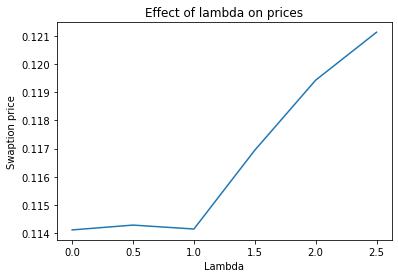

In [70]:
lmbdas = np.arange(0,3,0.5)

swaptions1 = [swaption(M,N,T0,K,l,a,b,chi,bonds,maturities) for l in lmbdas]
plt.figure()
plt.xlabel('Lambda')
plt.ylabel('Swaption price')
plt.title('Effect of lambda on prices')
plt.plot(lmbdas,swaptions1)
plt.show()

Execution time:  3.6695032119750977 sec
Execution time:  3.8047072887420654 sec
Execution time:  3.525923490524292 sec
Execution time:  3.869098663330078 sec
Execution time:  4.333787202835083 sec
Execution time:  4.191624879837036 sec
Execution time:  3.880371570587158 sec
Execution time:  3.853790044784546 sec


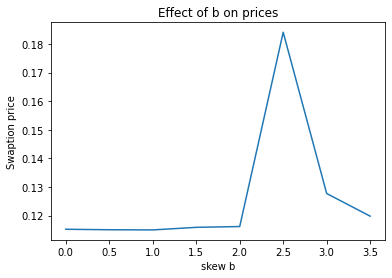

In [71]:
b_val = np.arange(0,4,0.5)

swaptions2 = [swaption(M,N,T0,K,lmbda,a,b,chi,bonds,maturities) for b in b_val]
plt.figure()
plt.xlabel('skew b')
plt.ylabel('Swaption price')
plt.title('Effect of b on prices')
plt.plot(b_val,swaptions2)
plt.show()

**Observation: As expected, an increase in $\lambda$ and b leads to an increase in the short rate volatility and then in the swaption volatility.**

Execution time:  3.893709182739258 sec
Execution time:  3.3953468799591064 sec
Execution time:  3.378762722015381 sec
Execution time:  3.268242597579956 sec
Execution time:  3.2618002891540527 sec
Execution time:  3.2953402996063232 sec
Execution time:  3.2469048500061035 sec
Execution time:  3.2810003757476807 sec
Execution time:  3.206709861755371 sec
Execution time:  3.2265565395355225 sec


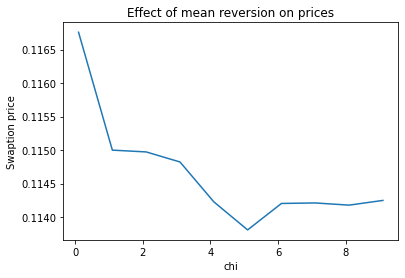

In [68]:
mean_reversion_val = np.arange(0.1,10,1)

swaptions = [swaption(M,N,T0,K,lmbda,a,b,mr,bonds,maturities) for mr in mean_reversion_val]
plt.figure()
plt.xlabel('chi')
plt.ylabel('Swaption price')
plt.title('Effect of mean reversion on prices')
plt.plot(mean_reversion_val,swaptions)
plt.show()

**Remark:** One observes that the swaption volatility decreases as the mean reversion increases as it is said p. 553 in Piterbarg. Indeed, the mean reversion parameter tends to keep the factor x around a mean level

## Extract Implied volatility

Assume that the swap rate $S$ is log-normal. We have the following diffusion $$\mathrm{d}S_{T0,...,T_N}(t) = S_{T0,...,T_N}(t)\sigma \ \mathrm{d}W_t$$ because it has to be a martingale under $\mathbb{Q}^A$ where $$\frac{\mathrm{d}\mathbb{Q}^A}{\mathrm{d}\mathbb{Q}}\Big| _{\mathcal{F}_t} = \frac{A(t)}{A(0)} e^{-\int_{0}^{t} r(s) \ \mathrm{d}s}$$

Hence $$\begin{array}{ll} V_0 &= \mathbb{E}_{\mathbb{Q}}\Big[ e^{-\int_{0}^{t} r(s) \ \mathrm{d}s} Swap(T_0)^+ \Big]
= A(0) \mathbb{E}_{\mathbb{Q}^A}\Big[ \big(S(T_0) -K \big) \mathbb{1}_{S(T_0)>K} \Big] \end{array}$$

Let $$\frac{\mathrm{d}\tilde{\mathbb{Q}}}{\mathrm{d}\mathbb{Q}^A} = \frac{S(T_0)}{\mathbb{E}[S(T_0)]} = e^{-\frac{\sigma^2}{2}T_0 + \sigma W_{T_0}}$$ and by Girsanov's Theorem, $$\tilde{W}_t = W^A_t - \sigma t$$ is a Brownian motion under $\tilde{\mathbb{Q}}$.

It leads to a Black Scholes formula by:
$$\begin{array}{ll} V_0 &= A(0)S(0) \tilde{\mathbb{Q}} \Big( e^{\frac{\sigma^2}{2}T_0 + \sigma \tilde{W}_{T_0}} > K \Big) \ -K A(0) \mathbb{Q}^A \Big( \sigma W_{T_0} > \ln{\frac{K}{S(0)}} + \frac{\sigma^2}{2} T_0 \Big) \\
&= \boxed{A(0)S(0) \Phi(d^+) \ -KA(0) \Phi(d^-)}
\end{array}$$

$$\left\{
    \begin{array}{ll}
       d^+ &= \frac{\ln{\frac{S(0)}{K}} + \frac{\sigma^2}{2} T_0}{\sigma \sqrt{T_0}} \\
       d^- &= d^+ - \sigma \sqrt{T_0}
    \end{array}
\right.$$

In particular, $\frac{\partial d^+}{\partial \sigma} = \frac{\partial d^-}{\partial \sigma} + \sqrt{T_0}$ and 
$$vega = \frac{\partial V_0}{\partial \sigma} = A(0)S(0) \frac{\partial d^+}{\partial \sigma} \phi(d^+) \ -K A(0) \frac{\partial d^-}{\partial \sigma} \phi(d^-) \\
= A(0)S(0) \sqrt{\frac{T_0}{2\pi}} e^{-\frac{(d^+)^2}{2}}$$ ($\Phi$ is the cdf of the standard normal law and $\phi$ its density function.)

First view of Black scholes prices to be sure that the pricing formula is right and that the asymptotic behavior is the expected one.

SO*A0= 0.5954216631743912


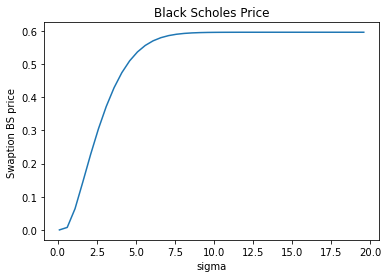

In [209]:
def Price_BS(S0,A0,T0,K,sigma):
    d = (np.log(S0/K) + 0.5*T0*sigma**2)/(sigma*np.sqrt(T0))
    return S0*A0* stats.norm.cdf(d) -K*A0*stats.norm.cdf(d-sigma*np.sqrt(T0))

T0 = maturities[0]
nb_maturities = maturities.size
A0 = sum([(maturities[i+1]-maturities[i])*bonds[i+1] for i in range(0,nb_maturities-1)])
S0 = (bonds[0]-bonds[-1])/A0
sigma_val = np.arange(0.1,20,0.5)
BS_prices = [Price_BS(S0,A0,T0,2*S0,s) for s in sigma_val]
print('SO*A0=',S0*A0)

plt.figure()
plt.xlabel('sigma')
plt.title('Black Scholes Price')
plt.ylabel('Swaption BS price ')
plt.plot(sigma_val,BS_prices)
plt.show()

### Newton-Raphson algorithm

The simple Newton-Raphson algorithm, applied to find the zero of the function $\sigma \rightarrow V_0(\sigma) - \hat{V}$ where $\hat{V}$ is the observed marked to market value of the swaption, is written:

$$\left\{
    \begin{array}{ll}
       \sigma_0 \quad \text{chosen}\\
       \sigma_{n+1} = \sigma_n - \bigg( \frac{V_0(\sigma_n) - \hat{V}}{\frac{\partial V_0}{\partial \sigma}(\sigma_n)} \bigg)
    \end{array}
\right.$$

In [185]:
def Newton_Raphson(sigma0, nb_it, Mtm, bonds, K, maturities):
    sigma = sigma0
    T0 = maturities[0]   
    nb_maturities = maturities.size
    A0 = sum([(maturities[i+1]-maturities[i])*bonds[i+1] for i in range(0,nb_maturities-1)])
    S0 = (bonds[0]-bonds[-1])/A0
    
    for i in range(nb_it):
        d = (np.log(S0/K) + 0.5*T0*sigma**2)/(sigma*np.sqrt(T0))
        price_BS = (bonds[0]-bonds[-1])* stats.norm.cdf(d) -K*A0*stats.norm.cdf(d-sigma*np.sqrt(T0))
        derivative = (bonds[0]-bonds[-1])*np.sqrt(T0/(2*np.pi))*np.exp(-0.5*d**2)
        sigma = sigma - (price_BS-Mtm)/derivative
        print("Sigma, derivative =",sigma, derivative)
    return sigma

Newton_Raphson(0.5,4,0.05,bonds,2,maturities)

Sigma, derivative = 0.5019070253981068 0.16268955219642028
Sigma, derivative = 0.5019064713365715 0.16278392189610755
Sigma, derivative = 0.5019064713365247 0.1627838946693356
Sigma, derivative = 0.5019064713365249 0.1627838946693333


0.5019064713365249

There is some instability with the Newton-Raphson algorithm because the derivative of the Black Scholes price tends to be very small.

In [202]:
def bissectrice(nb_it, Mtm, bonds, K, maturities):
    T0 = maturities[0]   
    nb_maturities = maturities.size
    A0 = sum([(maturities[i+1]-maturities[i])*bonds[i+1] for i in range(0,nb_maturities-1)])
    S0 = (bonds[0]-bonds[-1])/A0

    x = 0
    y = 1
    for i in range(nb_it):
        z = (x+y)/2
        sigma = 1/(1-z)
        price_BS = Price_BS(S0,A0,T0,K,sigma)

        if(Mtm > price_BS):
            x = z
        else:
            y = z
    z = (x+y)/2
    return z/(1-z)

bissectrice(10,0.05,bonds,2,maturities)

0.0004885197850512946

Divergence des algorithmes pour les mêmes valeurs -> probleme ?

### Effect of K

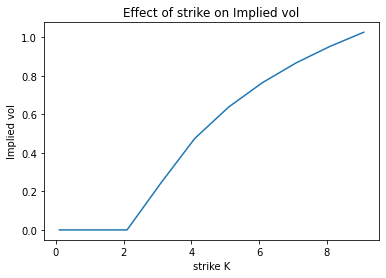

array([0.1, 1.1, 2.1, 3.1, 4.1, 5.1, 6.1, 7.1, 8.1, 9.1])

In [260]:
strikes = np.arange(0.1,10,1)
impli_vol = [bissectrice(10,0.1,bonds,k,maturities) for k in strikes]
plt.figure()
plt.xlabel('strike K')
plt.ylabel('Implied vol')
plt.title('Effect of strike on Implied vol')
plt.plot(strikes,impli_vol)
plt.show()
strikes

On devrait avoir une courbe décroissante

### Effect of T0

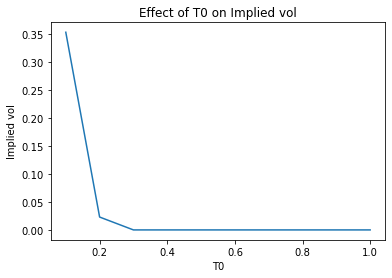

array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ])

In [265]:
T0s = np.arange(0.1,1.1,0.1)
impli_vol = [bissectrice(10,0.1,[np.exp(-r*m) for m in np.arange(t,5)],2,np.arange(t,5)) for t in T0s]
plt.figure()
plt.xlabel('T0')
plt.ylabel('Implied vol')
plt.title('Effect of T0 on Implied vol')
plt.plot(T0s,impli_vol)
plt.show()
T0s

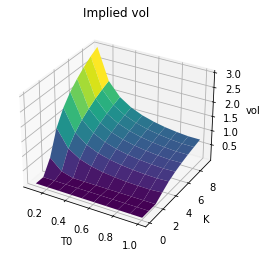

In [271]:
X,Y = np.meshgrid(T0s, strikes)

Z = np.array([[bissectrice(10,0.1,[np.exp(-r*m) for m in np.arange(t,5)],k,np.arange(t,5)) for t in T0s] for k in strikes])
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap='viridis', edgecolor='none')
ax.set_xlabel('T0')
ax.set_ylabel('K')
ax.set_zlabel('vol')
ax.set_title('Implied vol');

## Pricing by Gaussian swap rate approximation ( p.422 10.1.3.2)

$$V_0 \approx A(0) \Big[\big(S(0) -K \big) \Phi(d) \ + \ \sqrt{v} \phi(d) \Big] \\
d= \frac{S(0)-K}{\sqrt{v}} \quad v = \int_{0}^{T_0} q(t,\bar{x}(t))^2 \ \sigma_r(t)^2 \ \mathrm{d}t$$

Where $$q(t,x) = -\frac{P(t,T_0,x) G(t,T_0) - P(t,T_N,x)G(t,T_N)}{A(t,x)} \ + \ \frac{S(t,x)}{A(t,x)}\sum_{i=0}^{N-1} \tau_i P(t,T_{i+1},x) G(t,T_{i+1})$$